# [CS 4476/6476 Project 3: Local Feature Matching](https://sites.google.com/view/cs4476-6476-sp2020)

This iPython notebook:  
(1) Loads and resizes images  
(2) Finds interest points in those images                 (you code this)  
(3) Describes each interest point with a local feature    (you code this)  
(4) Finds matching features                               (you code this)  
(5) Visualizes the matches  
(6) Evaluates the matches based on ground truth correspondences  

## Setup

In [1]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from utils import *
from student_feature_matching import match_features, pca, accelerated_matching
from student_sift import get_features
from student_harris import get_interest_points
from IPython.core.debugger import set_trace


from proj3_unit_tests.harris_unit_test import (
    test_get_gradients,
    test_get_gradients2,
    test_gaussian_kernel, 
    test_second_moment, 
    test_corner_response, 
    test_get_interest_points,
    test_find_single_valid_corner,
    verify
)
from proj3_unit_tests.sift_unit_test import (
    test_get_magnitudes_and_orientations,
    test_get_feat_vec,
    test_get_features, 
)

from proj3_unit_tests.feature_match_test import (
    test_compute_dists,
    test_feature_matching,
    test_pca
)

                    

In [83]:
# Notre Dame
image1 = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg')
image2 = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg')
eval_file = '../data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'

In [73]:
# Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
image1 = load_image('../data/Mount Rushmore/9021235130_7c2acd9554_o.jpg')
image2 = load_image('../data/Mount Rushmore/9318872612_a255c874fb_o.jpg')
eval_file = '../data/Mount Rushmore/9021235130_7c2acd9554_o_to_9318872612_a255c874fb_o.pkl'

In [61]:
# Episcopal Gaudi -- This pair is relatively difficult
image1 = load_image('../data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg')
image2 = load_image('../data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg')
eval_file = '../data/Episcopal Gaudi/4386465943_8cf9776378_o_to_3743214471_1b5bbfda98_o.pkl'

In [84]:
scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

n_pts = 1500 # width and height of each local feature, in pixels. 

## Find distinctive points in each image (Szeliski 4.1.1)
### These are the results using the ground truth points

149 corners in image 1, 149 corners in image 2


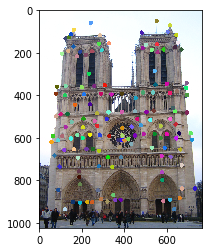

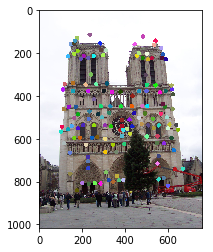

In [85]:
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
# plt.figure(); plt.imshow(image1_bw)
# Visualize the interest points
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

### This is where you implement and observe your results from get interest points

#### First some unit tests

In [86]:
## Verify each step in the code, this will check if your implementation is correct or not.

## Do not modify the constructor of any function (i.e. to take some custom arguments
## as input)


print("Gaussian Kernel:", verify(test_gaussian_kernel))
print('Gradients test 1:', verify(test_get_gradients))
print('Gradients test 2:', verify(test_get_gradients2))
print('Second Moments:', verify(test_second_moment))
print('Corner Response:', verify(test_corner_response))

Gaussian Kernel: "Correct"
Gradients test 1: "Correct"
Gradients test 2: "Correct"
Second Moments: "Correct"
Corner Response: "Correct"


#### Now run it all together

1498 corners in image 1, 1498 corners in image 2
Time Elapsed: 92.34048986434937


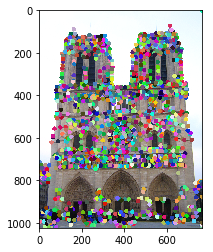

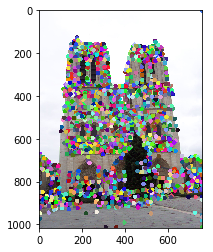

In [87]:
start = time.time()

x1, y1, R1, con1= get_interest_points(image1_bw, n_pts)
x2, y2, R2, con2= get_interest_points(image2_bw, n_pts)
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

end = time.time()
unoptimized = end - start
print('Time Elapsed: {}'.format(unoptimized))

In [88]:
print('Interest Points:', verify(test_get_interest_points))
print('Interest Points Single Corner:', verify(test_find_single_valid_corner))

Interest Points: "Correct"
Interest Points Single Corner: "Correct"


## Create feature vectors at each interest point (Szeliski 4.1.2)

#### This is where you will code the functions in student_sift.py. Run the following cell to test your implementation

In [89]:
print("Magnitudes and Orientations:", verify(test_get_magnitudes_and_orientations))
print('Feature Vector', verify(test_get_feat_vec))
print('All Feature Vectors', verify(test_get_features))

Magnitudes and Orientations: "Correct"
Feature Vector "Correct"
All Feature Vectors "Correct"


#### Collect features from our image pair

In [90]:
feature_width = 16
image1_features = get_features(image1_bw, x1, y1, feature_width)
image2_features = get_features(image2_bw, x2, y2, feature_width)

C:\Users\Evan\Desktop\CS4476\PS3\proj3_release\proj3_code\student_sift.py:103: RuntimeWarning: invalid value encountered in true_divide
  fv = fv/np.linalg.norm(fv,ord=2)


## Match features (Szeliski 4.1.3)

#### Complete compute_feature_distances() and feature_matching() in student_feature_matching.py. The following cell will test your implementations

In [91]:
print("Feature Distances:", verify(test_compute_dists))
print('Matches:', verify(test_feature_matching))

Feature Distances: "Correct"
Matches: "Correct"


#### Match features for our image pair

In [92]:
start = time.time()
matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
end = time.time()
unoptimized = end - start
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
print('Time Elapsed: {}'.format(unoptimized))

174 matches from 1498 corners
Time Elapsed: 26.984012603759766


## Visualization

You might want to set 'num_pts_to_visualize' and 'num_pts_to_evaluate' to some constant (e.g. 100) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. You can comment out one of both of them if you prefer.

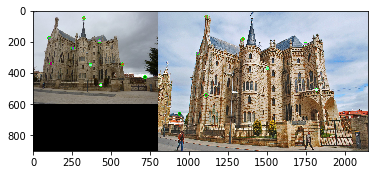

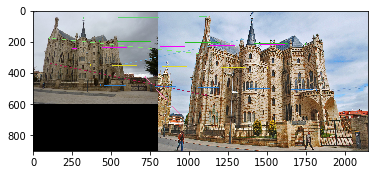

In [71]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles.png', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines.png', dpi=1000)

Comment out the function below if you are not testing on the Notre Dame, Episcopal Gaudi, and Mount Rushmore image pairs--this evaluation function will only work for those which have ground truth available.  
  
You can use `annotate_correspondences/collect_ground_truth_corr.py` to build the ground truth for other image pairs if you want, but it's very tedious. It would be a great service to the class for future years, though!

You found 9/100 required matches
Accuracy = 0.010000


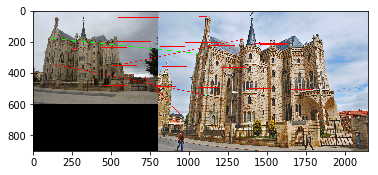

In [72]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval.png', dpi=1000)

## Bells and Whistles tests

### PCA

In [ ]:
print("PCA: ", verify(test_pca))

In [ ]:
n_components = 24
start = time.time()
reduced_image1_features, reduced_image2_features = pca(image1_features, image2_features, n_components)
matches, confidences = match_features(reduced_image1_features, reduced_image2_features, x1, y1, x2, y2)
end = time.time()
pca_optimized = end - start
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
print('Time Elapsed (PCA): {}'.format(pca_optimized))
print('Time Elapsed (no optimization): {}'.format(unoptimized))

In [ ]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles.png', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines.png', dpi=1000)

In [ ]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval.png', dpi=1000)

### Accelerated Matching

In [ ]:
start = time.time()
matches, confidences = accelerated_matching(image1_features, image2_features, x1, y1, x2, y2)
end = time.time()
accelerated = end - start
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
print('Time Elapsed (Accelerated): {}'.format(accelerated))
print('Time Elapsed (PCA): {}'.format(pca_optimized))
print('Time Elapsed (no optimization): {}'.format(unoptimized))

In [ ]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles.png', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines.png', dpi=1000)

In [ ]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval.png', dpi=1000)